# Step by step preprocessing

Fist, we need to import the packages. We will need nilearn (learning algorithms and image manipulation), pandas and numpy (data structures manipulation).

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import nilearn

from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn import masking
from nilearn import decoding
from nilearn.image import mean_img
from nilearn.image import math_img
from nilearn.decoding import Decoder 

from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.glm.first_level import FirstLevelModel

from nilearn.plotting import plot_design_matrix

from timeit import default_timer as timer
from datetime import timedelta

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

/home/brunomiguel/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


## Let's look at the raw data (i.e. data as acquired)

To start, we need to inform the software where are the data.


In [2]:
# Set variables
ROOT_DATA='/Users/home/Documents/BIDS/'
ROOT_DATA='/home/brunomiguel/Documents/data/BIDS/'
SUB='sub-0002'
SES='ses-001'
TASK='nomeacaoinner'
RUN='run-01'


# data folder
data_path=os.path.join(ROOT_DATA, SUB, SES)
print('The data is in this folder - ' + data_path)

# project folder
ROOT_PROJECT="/Users/home/Documents/GitHub/MVPA-speech_project"



The data is in this folder - /home/brunomiguel/Documents/data/BIDS/sub-0002/ses-001


# Structural data.

## Raw data.

Let's look at the raw data.

/home/brunomiguel/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:527: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


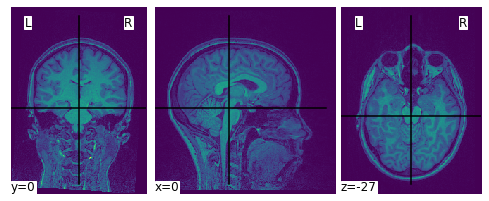

In [3]:
t1w_fp=os.path.join(data_path, 'anat', 
                           SUB + '_' + SES + '_run-01_T1w.nii.gz')
plotting.plot_img(t1w_fp)

First we used the FSL toolbox to preprocess the structural image. 

https://www.youtube.com/watch?v=VobRXk3ccNQ

BET - Brain extraction.
https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/BET/UserGuide

(used default values - with Fractional intensity threshold of 0.5)

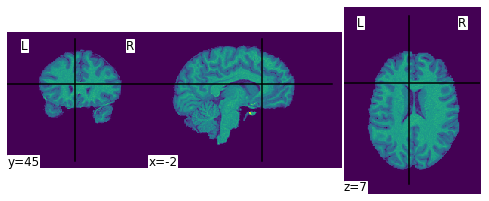

In [4]:
t1w_brain_fp=os.path.join(data_path, 'anat', SUB + '_' + SES + '_run-01_T1w.anat',
                                 'T1_biascorr_brain.nii.gz')

plotting.plot_img(t1w_brain_fp)

## Functional data preprocessing

Raw functional data.


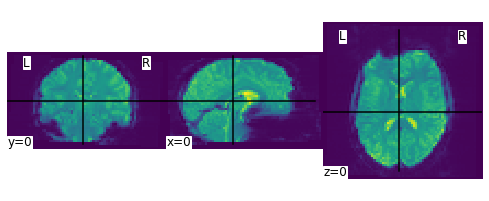

In [5]:
func_data_pp=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-' + TASK + '_'+ RUN +'_bold.nii.gz')

# Mean image  to check motion correction.
m_img=mean_img(func_data_pp)
                          
# coordinates to place cross in mean image.
cut_coords=(0, 0, 0)

# Plot mean functional image.
plotting.plot_img(m_img, cut_coords)

Second step includes the FEAT - fMRI Expert Analysis Tool https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/FEAT.

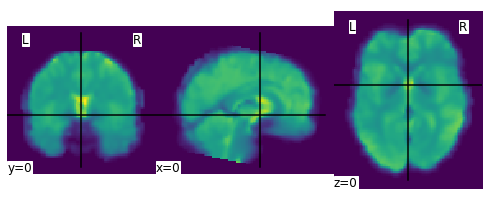

In [6]:
func_data_pp=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_pp_standard.nii.gz')

# Mean image  to check motion correction.
m_img=mean_img(func_data_pp)

# Create a mask.
mask=masking.compute_epi_mask(m_img)
                          
# coordinates to place cross in mean image.
cut_coords=(0, 0, 0)

# Plot mean functional image.
plotting.plot_img(m_img, cut_coords)

We see the data smoothed and registered to MNI standard.

How many images do we have in this dataset?

In [7]:
func_d_img=image.load_img(func_data_pp)

func_d_img=image.clean_img(func_d_img, ensure_finite=True)

n_imgs=func_d_img.shape[3]
print('this dataset has ' + str(n_imgs) + ' images.')

this dataset has 125 images.


## Design matrix.

Let us look at the events over time.

In [8]:
# repetition time - acquisition parameter.
tr=3  

# here are the correspoding onset times.
frame_times = np.arange(n_imgs) * tr  

# load events.tsv
events_fn=os.path.join(data_path, 'func', 
                          SUB + '_' + SES + 
                          '_task-' + TASK + '_'+ RUN + '_events.tsv')

events_df=pd.read_csv(events_fn, sep='\t', na_values="n/a")
print(events_df)
print(events_df.shape)

     trial_type  onset  duration
0             0      0         3
1             0      3         3
2             0      6         3
3             0      9         3
4             0     12         3
..          ...    ...       ...
120           0    360         3
121           0    363         3
122           0    366         3
123           0    369         3
124           0    372         3

[125 rows x 3 columns]
(125, 3)


Everything looks fine! shape

<AxesSubplot:label='conditions', ylabel='scan number'>

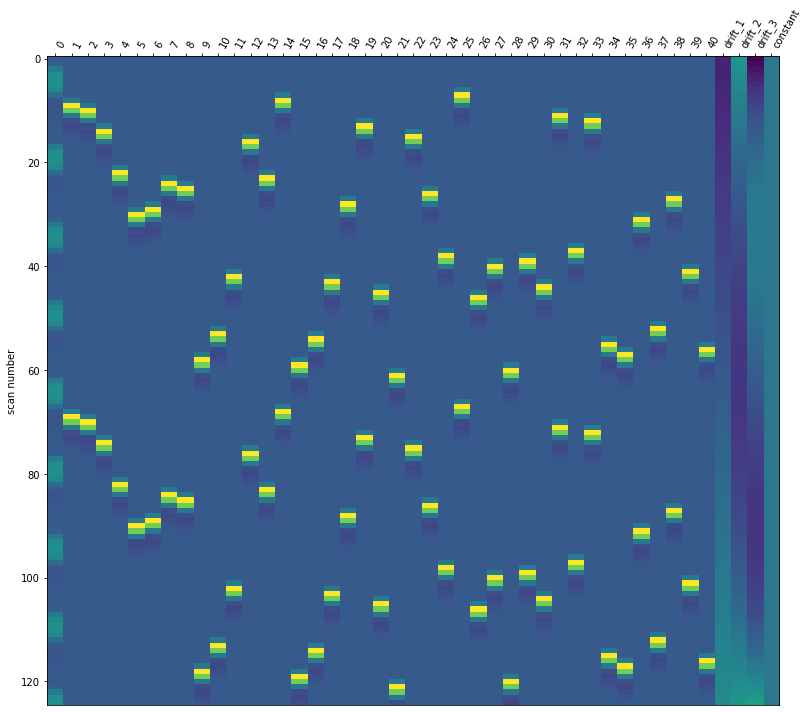

In [9]:
# Define the HRF function.
hrf_model='spm'

# Set the corresponding design matrix.
design_matrix = make_first_level_design_matrix(events_df['onset'], events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

In [10]:
events_bs=events_df.copy()
events_bs.drop(index=events_bs.index[-4:], 
        axis=0, 
        inplace=True)

print(events_bs)

     trial_type  onset  duration
0             0      0         3
1             0      3         3
2             0      6         3
3             0      9         3
4             0     12         3
..          ...    ...       ...
116           9    348         3
117          15    351         3
118          28    354         3
119          21    357         3
120           0    360         3

[121 rows x 3 columns]


     trial_type  onset  duration
0             0      0         3
1             1      3         3
2             2      6         3
3             3      9         3
4             4     12         3
..          ...    ...       ...
116         116    348         3
117         117    351         3
118         118    354         3
119         119    357         3
120         120    360         3

[121 rows x 3 columns]
Fitting a GLM
[              0         1         2         3    4    5    6    7    8    9  \
0.0    0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
3.0    0.098025  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
6.0    0.564368  0.098025  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
9.0    0.394139  0.564368  0.098025  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
12.0   0.088186  0.394139  0.564368  0.098025  0.0  0.0  0.0  0.0  0.0  0.0   
...         ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
360.0  0.000

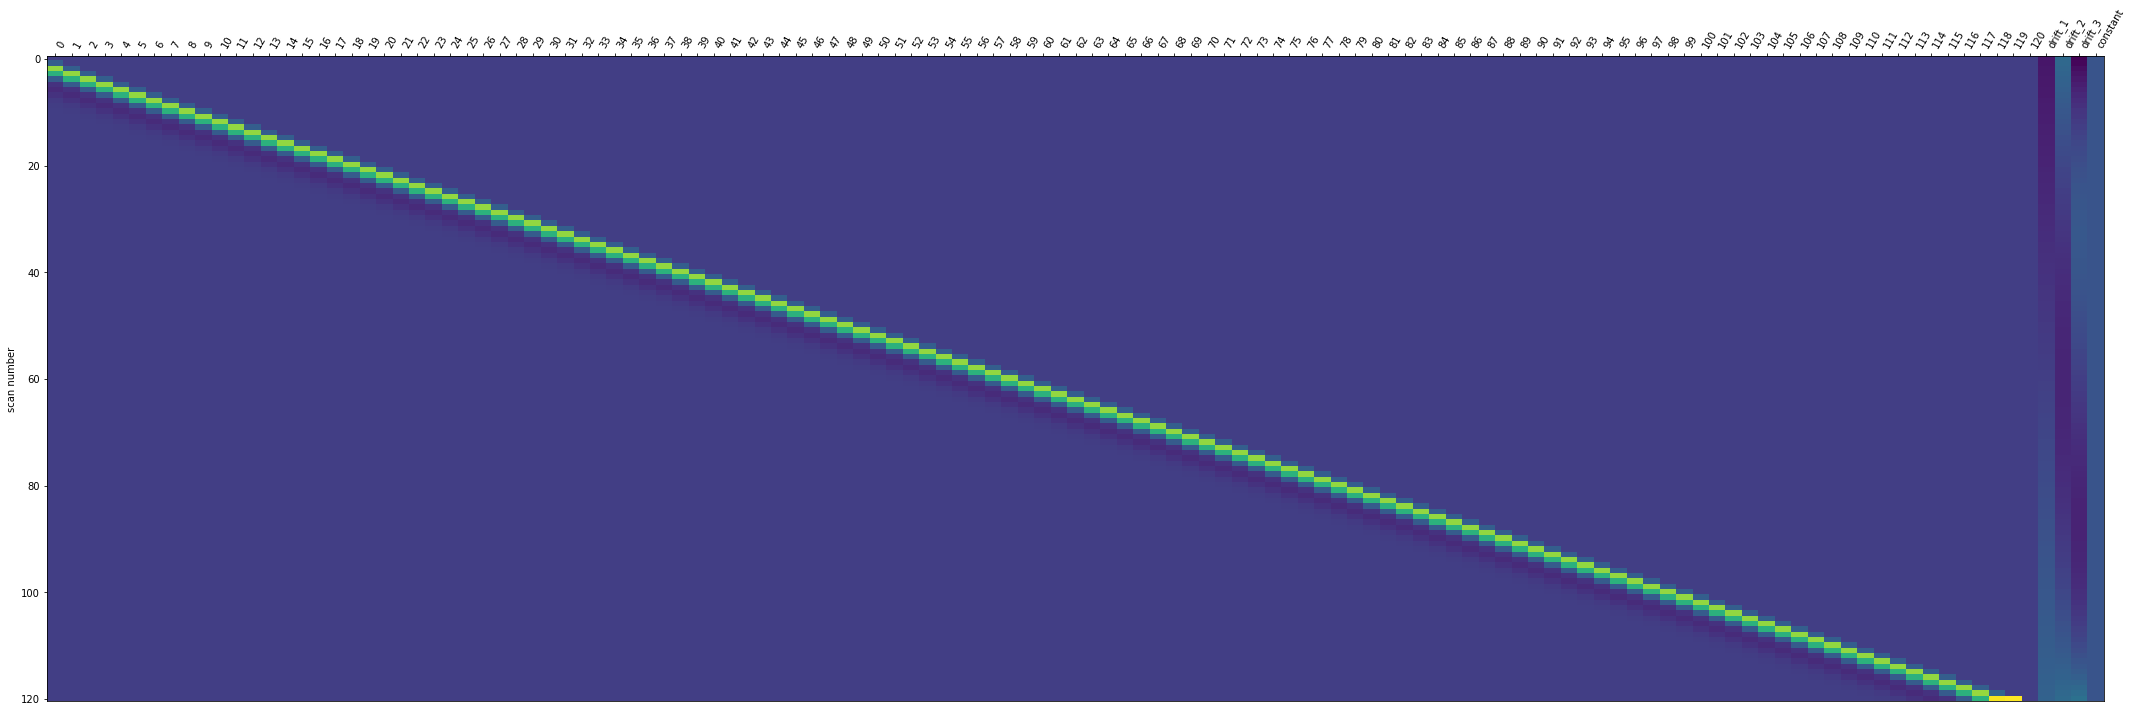

In [11]:
events_bs['trial_type']=range(len(events_bs))

print(events_bs)

# Set the corresponding design matrix.
design_matrix_bs = make_first_level_design_matrix(events_bs['onset'], events_bs,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)
plot_design_matrix(design_matrix_bs)

# Fit GLM models for all contrasts/predictors
print('Fitting a GLM')
fmri_glm = FirstLevelModel(t_r=tr, hrf_model='spm', mask_img=mask, drift_model=None)
fmri_glm.fit(func_data_pp, events_bs)

print(fmri_glm.design_matrices_)


In [12]:
fmri_glm.design_matrices_

[              0         1         2         3    4    5    6    7    8    9  \
 0.0    0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 3.0    0.098025  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 6.0    0.564368  0.098025  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 9.0    0.394139  0.564368  0.098025  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 12.0   0.088186  0.394139  0.564368  0.098025  0.0  0.0  0.0  0.0  0.0  0.0   
 ...         ...       ...       ...       ...  ...  ...  ...  ...  ...  ...   
 360.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 363.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 366.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 369.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 372.0  0.000000  0.000000  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
 
        ...       112       113       

In [13]:
contrast_mat=np.eye(len(events_bs), len(events_bs)+1)
#contrast_mat[np.where(contrast_mat == 0)]=-1

print(contrast_mat)
print(contrast_mat.shape)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
(121, 122)


In [14]:
z_maps=[]

for contrast in contrast_mat:
    #print(contrast)
    #print(contrast.shape)
    z_maps.append(fmri_glm.compute_contrast(contrast))
    
print(len(z_maps))

# housekeeping for memory management
del fmri_glm, func_d_img

121


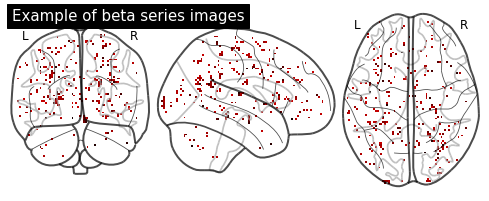

In [15]:
# Example plot of the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_glass_brain(
    z_maps[7], threshold=3.0, title='Example of beta series images')
plotting.show()


#bs_fn=os.path.join(data_path, 'func', SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')
import nibabel as nib

bs_fn=os.path.join('data', SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')

img4D=nilearn.image.concat_imgs(z_maps)
#nib.save(z_maps, bs_fn)

#z_maps.to_filename(bs_fn)

In [16]:
img4D.to_filename(bs_fn)

## Mask Selection

In [17]:

from nilearn.datasets import fetch_icbm152_brain_gm_mask
mask = fetch_icbm152_brain_gm_mask()

#dataset = datasets.fetch_atlas_harvard_oxford('cort-maxprob-thr25-2mm') 
#atlas_filename = dataset.maps

#print(dataset)



In [18]:
#mask = mean_img([math_img('img == %d'  %i, img=atlas_filename) for i in [48]])
#plotting.view_img(mask)

## Decoding

Let's start with the decoding - first initialize the classifier

In [19]:

cv=2

bs_fn=os.path.join('data', SUB + '_' + SES + '_task-' + TASK + '_'+ RUN +'_bold_bs.nii.gz')

img4D=nilearn.image.load_img(bs_fn)

decoder=Decoder(estimator='svc', mask=mask, cv=cv, standardize=True,
                  screening_percentile=2) 

Now we need to select data for the training set! 2/3 of the data.

In [20]:
#TODO

Let's train the decoder with training data.

In [ ]:

# init timer()
fit_start=timer()

decoder.fit(img4D,events_df['trial_type'][:-4])

# stop timer()
fit_end=timer()

# print elapsed time for model training
print(timedelta(seconds=fit_end-fit_start))

In [ ]:

print(decoder.cv_scores_) 


In [ ]:
plotting.view_img(
    decoder.coef_img_[0],
    title="SVM weights", dim=-1
)

In [ ]:
classification_accuracy = np.mean(list(decoder.cv_scores_.values()))
print(classification_accuracy)

In [ ]:
from sklearn.model_selection import permutation_test_score

null_cv_scores = permutation_test_score(
    decoder, z_maps, events_df['trial_type'][:-4], cv=cv)
print(null_cv_scores)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score

null_cv_scores = cross_val_score(
    DummyClassifier(), z_maps, events_df['trial_type'][:-4], cv=cv)
print(null_cv_scores)

In [ ]:
del z_maps